In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import PIL.Image
import IPython.display as display
import requests
from io import BytesIO

import tensorflow as tf
from tensorflow.keras.applications import VGG19

from tensorflow.keras.models import Model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neural-style-transfer/content3.jpeg
/kaggle/input/neural-style-transfer/content1.jpg
/kaggle/input/neural-style-transfer/content6.jpg
/kaggle/input/neural-style-transfer/style2.jpg
/kaggle/input/neural-style-transfer/style1.jpg
/kaggle/input/neural-style-transfer/style6.jpg
/kaggle/input/neural-style-transfer/content5.jpg
/kaggle/input/neural-style-transfer/style4.jpeg
/kaggle/input/neural-style-transfer/content7.jpg
/kaggle/input/neural-style-transfer/style5.jpg
/kaggle/input/neural-style-transfer/content4.jpg
/kaggle/input/neural-style-transfer/style7.jpg
/kaggle/input/neural-style-transfer/content2.jpg
/kaggle/input/neural-style-transfer/style3.jpg


In [103]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [104]:
max_dim = 512

def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)

def load_img_from_url(url):
    # Fetch image from the URL
    response = requests.get(url)
    img_data = BytesIO(response.content)
    
    # Decode the image
    img = tf.io.decode_image(img_data.read(), channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize the image to the desired dimensions
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)

    # Add batch dimension
    img = img[tf.newaxis, :]
    return img

In [105]:
style_path   = "/kaggle/input/neural-style-transfer/style4.jpeg"
content_path = "/kaggle/input/neural-style-transfer/content2.jpg"
content_path2 = "https://scontent.fczl2-1.fna.fbcdn.net/v/t1.6435-9/131330609_834405654006051_7426416413013009419_n.jpg?_nc_cat=102&ccb=1-7&_nc_sid=2285d6&_nc_eui2=AeEWj9AnUoYSr7npf68FmMVysSlEgJHrJ8GxKUSAkesnwYhDVMf24p8_yW7GOzm-bYkT3IDng7xyXi3yvsD5HqKV&_nc_ohc=Gr-T885SOGoQ7kNvgEn08RL&_nc_ht=scontent.fczl2-1.fna&_nc_gid=AKo1pnnwWHNxweWiLwVgbix&oh=00_AYCZokTKaDYI75uZ4rqW_8jZ-7T5J36NcmbF-TP8nK7lsA&oe=670D6BDE"


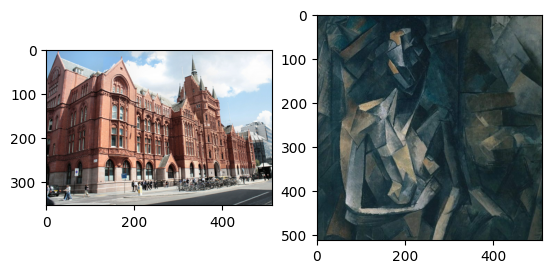

In [106]:
content_image = load_img(content_path)
style_image = load_img(style_path)


plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Build The model

In [107]:
vgg = VGG19(include_top=False, weights='imagenet')

vgg.trainable = False

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_12
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [108]:
content_layers = ['block5_conv2',] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
all_layers =  style_layers + content_layers

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print(all_layers)

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1', 'block5_conv2']


In [109]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [110]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  675.8868
  mean:  12.291868

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  2705.6575
  mean:  73.73664

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  4689.915
  mean:  68.589554

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  11107.314
  mean:  301.4008

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  1823.9828
  mean:  23.524506



In [111]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [112]:
class NSTModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(NSTModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.len_style_layers = len(style_layers)

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.len_style_layers],
                                      outputs[self.len_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [113]:
extractor = NSTModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))


## Gradient descent

In [114]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [125]:
image = tf.Variable(content_image)

In [116]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [117]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [124]:
style_weight=1e-2
content_weight=1e4
total_variation_weight=30


In [119]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [120]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)
    
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [121]:
tf.debugging.set_log_device_placement(True)


In [122]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


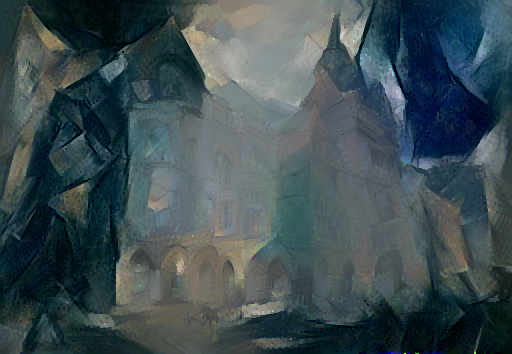

Train step: 100
.....................................

KeyboardInterrupt: 

In [136]:
import time
start = time.time()
tf.debugging.set_log_device_placement(True)


epochs = 20
steps_per_epoch = 100

step = 0
with tf.device('/GPU:1'):
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))

In [ ]:
model.save('model.h5')

In [ ]:
def pred(content_image,style_image,init_image=None,style_weight=1e-2,content_weight=1e4,total_variation_weight=30,epochs = 1,steps_per_epoch = 100):
    
    style_weight=style_weight
    content_weight=content_weight
    total_variation_weight=total_variation_weight
    style_extractor = vgg_layers(style_layers)
    style_outputs = style_extractor(style_image*255)
    
    image = tf.Variable(init_image if init_image != None else content_image)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    
    epochs = epochs
    steps_per_epoch = steps_per_epoch

    step = 0
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    
    with tf.device(device):
        for n in range(epochs):
          for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(".", end='', flush=True)
          display.clear_output(wait=True)
          display.display(tensor_to_image(image))
          print("Train step: {}".format(step))

        end = time.time()
        print("Total time: {:.1f}".format(end-start))
        plt.subplot(1, 2, 1)
        imshow(content_image, 'Content Image')

        plt.subplot(1, 2, 2)
        imshow(style_image, 'Style Image')

In [ ]:
pred(content_image,style_image)